In [57]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split  

from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import itertools

import warnings
warnings.filterwarnings("ignore")

import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "png"
png_renderer = pio.renderers["png"]
png_renderer.width = 1200
png_renderer.height = 700


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

In [3]:
def finam_load(filename, candles_):
    
    df = pd.read_csv(filename, sep=',')
    df.columns = [str(x)[1:-1] for x in df.columns]
    df['TIME'] = df['TIME'].apply(lambda x: '0'+str(x) if len(str(x)) < 6 else x)
    df.DATE = pd.to_datetime(df['DATE'].astype(str) + ' ' + df['TIME'].astype(str),
                             format='%Y%m%d %H:%M:%S')
    df = df[['DATE', candles_]].rename(columns={'DATE': 'ds',
                                               candles_: filename.split('_')[0]
                                              })
    return df

In [4]:
sber = finam_load('SBER_190101_200101.txt', candles_='CLOSE')

usd_rur = finam_load('USDRUB_190101_200101.txt', candles_='CLOSE')

df = sber.merge(usd_rur, on='ds', how='left')

df = df.rename(columns={'SBER': 'y'})

df['monthday'] = df.ds.dt.day
df['weekday'] = df.ds.dt.weekday

In [5]:
div_date = '2019-10-01'

df = df[df.ds.dt.hour == 18]

train, test = df[df.ds < div_date], df[df.ds >= div_date]

In [6]:

def shift_columns(data, column_lst, shifting_periods_lst=[7], drop=False):

    for column in column_lst:
        for period_ in shifting_periods_lst:
            sft_col = column + '_shift_{}'.format(period_)
            data[sft_col] = data[column].shift(period_)

    if drop:
        data = data.dropna()

    return data


df = shift_columns(df, ['USDRUB'], [7, 14], True)

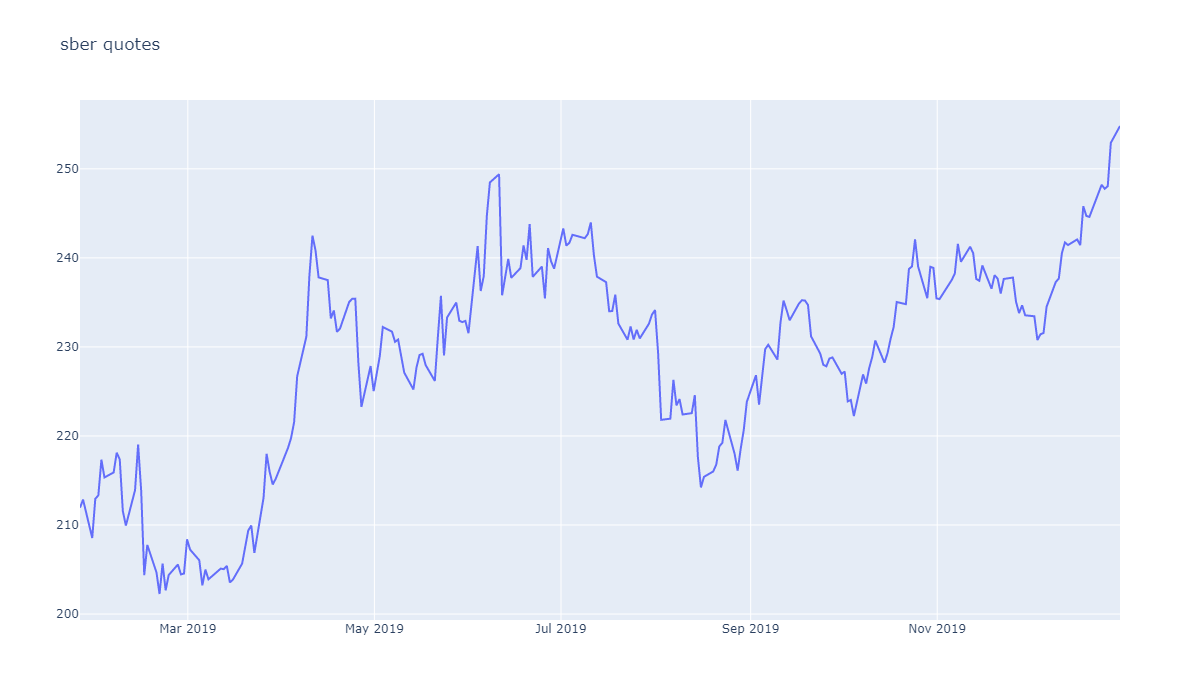

In [58]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=df.ds, y=df.y, mode='lines', name='sber_true'))

fig.update_layout(title='sber quotes', autosize=False,
                 width=1000, height=600)

fig.show()

In [8]:
from alm_lstm import DataLoader, LSTM_ts

In [9]:
DL = DataLoader(df, 
                categorical_features_names=['monthday', 'weekday'], 
                continuous_features_names=[x for x in df.columns if 'USDRUB' in x],
                target_name='y', 
                seq_lenght=7)

In [10]:
DL.data.head()

,ds,y,USDRUB,monthday,weekday,USDRUB_shift_7,USDRUB_shift_14
133,2019-01-24 18:00:00,211.94,65.8720,24,3,67.0918,68.9979
142,2019-01-25 18:00:00,212.85,66.1517,25,4,66.7800,67.9258
151,2019-01-28 18:00:00,208.54,65.9750,28,0,66.4376,66.9450
160,2019-01-29 18:00:00,212.94,66.2356,29,1,66.2998,67.0045
169,2019-01-30 18:00:00,213.33,65.9444,30,2,66.4350,67.0392


### DataLoader transform explain

#### categorical features

In [11]:
cat_feat = DL.categorical_features_embedding()
print(cat_feat.shape)
cat_feat

(238, 19)


array([[-2.116843  , -0.74732953, -1.4562455 , ...,  0.27522853,
         0.73714536, -0.32272062],
       [ 0.5865524 ,  1.0689526 ,  0.18582273, ...,  0.8632866 ,
         0.3993091 ,  1.1393634 ],
       [-1.7850888 ,  1.5526147 , -1.4624825 , ...,  0.39072987,
         0.31459382, -0.6215529 ],
       ...,
       [ 0.14133558,  0.40442303, -0.12393844, ...,  0.27522853,
         0.73714536, -0.32272062],
       [ 0.29279062,  0.7109769 , -1.9196857 , ...,  0.8632866 ,
         0.3993091 ,  1.1393634 ],
       [-0.9575826 , -1.7582135 , -1.1761224 , ...,  0.39072987,
         0.31459382, -0.6215529 ]], dtype=float32)

In [12]:
cat_feat_scale = DL.categorical_features_scale(cat_feat)
print(cat_feat_scale.shape)
cat_feat_scale

(238, 19)


array([[0.        , 0.24713671, 0.24160248, ..., 0.6566471 , 0.72899413,
        0.3364141 ],
       [0.69557595, 0.6911738 , 0.61021245, ..., 1.        , 0.5790682 ,
        1.        ],
       [0.08535942, 0.80941755, 0.24020243, ..., 0.7240855 , 0.54147303,
        0.20078516],
       ...,
       [0.581023  , 0.5287124 , 0.54067755, ..., 0.6566471 , 0.72899413,
        0.3364141 ],
       [0.6199919 , 0.6036574 , 0.13756987, ..., 1.        , 0.5790682 ,
        1.        ],
       [0.29827443, 0.        , 0.30448428, ..., 0.7240855 , 0.54147303,
        0.20078516]], dtype=float32)

In [13]:
cat_feat_scale_sequence = DL.prepare_sequence(cat_feat_scale)
print(cat_feat_scale_sequence.shape)
cat_feat_scale_sequence[0, :, :]

(231, 7, 19)


array([[0.        , 0.24713671, 0.24160248, 0.76753545, 0.5803916 ,
        0.9999999 , 0.34109545, 0.87267256, 0.7075584 , 0.36374524,
        0.5934587 , 0.7016037 , 0.        , 0.56768817, 0.55573547,
        0.25997716, 0.6566471 , 0.72899413, 0.3364141 ],
       [0.69557595, 0.6911738 , 0.61021245, 0.65456784, 0.8377161 ,
        0.13143027, 0.59070396, 0.60348696, 0.35423923, 0.65661466,
        0.48617184, 0.28493947, 0.6043526 , 0.5931291 , 0.76264966,
        0.12572205, 1.        , 0.5790682 , 1.        ],
       [0.08535942, 0.80941755, 0.24020243, 0.882635  , 0.7092557 ,
        0.00356019, 0.59190583, 0.64024204, 0.596773  , 0.5935736 ,
        0.5361278 , 0.4929202 , 0.4242087 , 0.4823299 , 0.5579893 ,
        0.7754623 , 0.7240855 , 0.54147303, 0.20078516],
       [0.3243192 , 0.65476215, 0.38589975, 0.9085564 , 0.52163494,
        0.34053445, 0.89284605, 0.6113738 , 0.38699237, 0.5158783 ,
        0.6840473 , 0.04926118, 0.67455184, 0.6211179 , 0.60092854,
        0.126

#### continuous features & target

#### sequence explain

In [14]:
cont_feat = DL.data[[x for x in DL.data.columns if 'USDRUB' in x]]
target = np.array(DL.data['y'].copy().values).reshape(-1, 1)

In [15]:
cont_feat_sequence, target = DL.prepare_sequence(np.array(cont_feat), target)
print(cont_feat_sequence.shape, target.shape )

(231, 7, 3) (231, 1)


In [16]:
cont_feat_sequence[0]

array([[65.872 , 67.0918, 68.9979],
       [66.1517, 66.78  , 67.9258],
       [65.975 , 66.4376, 66.945 ],
       [66.2356, 66.2998, 67.0045],
       [65.9444, 66.435 , 67.0392],
       [65.3013, 66.4765, 66.9649],
       [65.4389, 66.1452, 67.1741]])

In [17]:
df[['y'] + cont_feat.columns.to_list()][:7]

,y,USDRUB,USDRUB_shift_7,USDRUB_shift_14
133,211.94,65.8720,67.0918,68.9979
142,212.85,66.1517,66.7800,67.9258
151,208.54,65.9750,66.4376,66.9450
160,212.94,66.2356,66.2998,67.0045
169,213.33,65.9444,66.4350,67.0392
178,217.33,65.3013,66.4765,66.9649
187,215.34,65.4389,66.1452,67.1741


In [18]:
target[0]

array([215.34])

In [19]:
cont_feat_scale = DL.continuous_features_scale(cont_feat)
print(cont_feat_scale.shape)
cont_feat_scale[:10]

(238, 3)


array([[0.78792896, 1.        , 1.        ],
       [0.84055163, 0.93383835, 0.83182217],
       [0.80730734, 0.86118361, 0.67796637],
       [0.85633654, 0.83194347, 0.68729999],
       [0.80155027, 0.86063191, 0.6927433 ],
       [0.68055765, 0.8694379 , 0.68108803],
       [0.70644567, 0.7991385 , 0.71390475],
       [0.7372065 , 0.74116748, 0.70099454],
       [0.71203341, 0.80051775, 0.6520832 ],
       [0.7784279 , 0.76302332, 0.59837171]])

In [20]:
y_scale = DL.y_scale()
print(y_scale.shape)
y_scale[:5]

(238, 1)


array([[0.18436073],
       [0.20167428],
       [0.11967275],
       [0.20338661],
       [0.2108067 ]])

In [21]:
cont_feat_scale_sequence, y_scale_sequence = DL.prepare_sequence(cont_feat_scale, y_scale)
print(cont_feat_scale_sequence.shape, y_scale_sequence.shape)
cont_feat_scale_sequence[:1]

(231, 7, 3) (231, 1)


array([[[0.78792896, 1.        , 1.        ],
        [0.84055163, 0.93383835, 0.83182217],
        [0.80730734, 0.86118361, 0.67796637],
        [0.85633654, 0.83194347, 0.68729999],
        [0.80155027, 0.86063191, 0.6927433 ],
        [0.68055765, 0.8694379 , 0.68108803],
        [0.70644567, 0.7991385 , 0.71390475]]])

In [22]:
DL.continuous_features.shape, DL.categorical_features.shape, DL.y.shape

((238, 3), (238, 19), (238, 1))

In [23]:
DL.sequence_features()

In [24]:
DL.continuous_features.shape, DL.categorical_features.shape, DL.y.shape

((231, 7, 3), (231, 7, 19), (231, 1))

In [25]:
cont_feat_scale_sequence = torch.tensor(cont_feat_scale_sequence, dtype=torch.float)
cat_feat_scale_sequence = torch.tensor(cat_feat_scale_sequence, dtype=torch.float)
y_scale_sequence = torch.tensor(y_scale_sequence, dtype=torch.float)

### LSTM

In [27]:
DL = DataLoader(df, 
                categorical_features_names=['monthday', 'weekday'], 
                continuous_features_names=[x for x in df.columns if 'USDRUB' in x],
                target_name='y', 
                seq_lenght=10)

In [28]:
DL.data.head()

,ds,y,USDRUB,monthday,weekday,USDRUB_shift_7,USDRUB_shift_14
133,2019-01-24 18:00:00,211.94,65.8720,24,3,67.0918,68.9979
142,2019-01-25 18:00:00,212.85,66.1517,25,4,66.7800,67.9258
151,2019-01-28 18:00:00,208.54,65.9750,28,0,66.4376,66.9450
160,2019-01-29 18:00:00,212.94,66.2356,29,1,66.2998,67.0045
169,2019-01-30 18:00:00,213.33,65.9444,30,2,66.4350,67.0392


In [29]:
cat_feat_scale_sequence, cont_feat_scale_sequence, y_scale_sequence = DL.transform()

In [30]:
batch_size = df.shape[0]
test_size = int(0.2 * batch_size)

x = Variable(torch.cat([cont_feat_scale_sequence, cat_feat_scale_sequence], axis=2))
X_train = x[:batch_size - test_size]
X_test = x[batch_size - test_size: batch_size]

y_train = y_scale_sequence[:batch_size - test_size]
y_test = y_scale_sequence[batch_size - test_size: batch_size]


cat_feat_train = cat_feat_scale_sequence[:batch_size - test_size]
cont_feat_train = cont_feat_scale_sequence[:batch_size - test_size]

cat_feat_test = cat_feat_scale_sequence[batch_size - test_size: batch_size]
cont_feat_test = cont_feat_scale_sequence[batch_size - test_size: batch_size]

In [47]:
torch.manual_seed(13)

#nn.LSTM parameters
input_size = cont_feat_scale_sequence.shape[2] + cat_feat_scale_sequence.shape[2] 
hidden_size = 30
num_layers = 2
dropout = 0.3

#LSTM_ts parameters
seq_lenght = 10
output_size = 1
embed_dropout = 0.3

model = LSTM_ts(seq_lenght=seq_lenght,
                output_size=output_size, 
                embed_dropout=embed_dropout,
                input_size=input_size,
                hidden_size=hidden_size,
                num_layers=num_layers,
                dropout = dropout)
model

LSTM_ts(
  (embed_drop): Dropout(p=0.3, inplace=False)
  (bn_cont): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm): LSTM(22, 30, num_layers=2, batch_first=True, dropout=0.3)
  (fc): Linear(in_features=30, out_features=1, bias=True)
)

In [48]:
epochs = 201

loss_func= nn.MSELoss()       ## Convert into RMSE later
optimizer= torch.optim.Adam(model.parameters(), lr=0.01)

Epoch number: 200 and the Loss: 0.04285562038421631


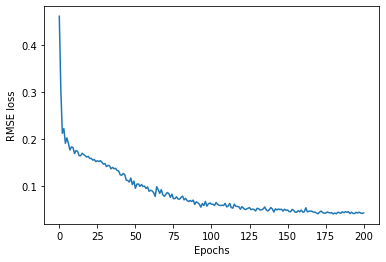

In [49]:
from IPython.display import clear_output
import matplotlib.pyplot as plt

model.train() #!!!!

final_losses = []
for i in range(epochs):

    y_pred = model(cont_feat_train, cat_feat_train)
    loss = torch.sqrt(loss_func(y_pred, y_train))     ## RMSE
    
    final_losses.append(loss)
    if i % 50 == 0:
        
        clear_output()
        print("Epoch number: {} and the Loss: {}".format(i, loss.item()))
        plt.plot(range(i + 1), final_losses)
        plt.ylabel('RMSE loss')
        plt.xlabel('Epochs')
        plt.show()        

        
    optimizer.zero_grad()
    loss.backward()         ##back propogation
    optimizer.step()

In [50]:
model.eval()
train_predict = model(X_test)

data_predict = train_predict.data.numpy()
dataY_plot = y_test.data.numpy()

data_predict = DL.get_Scaler().inverse_transform(data_predict)
dataY_plot = DL.get_Scaler().inverse_transform(dataY_plot)

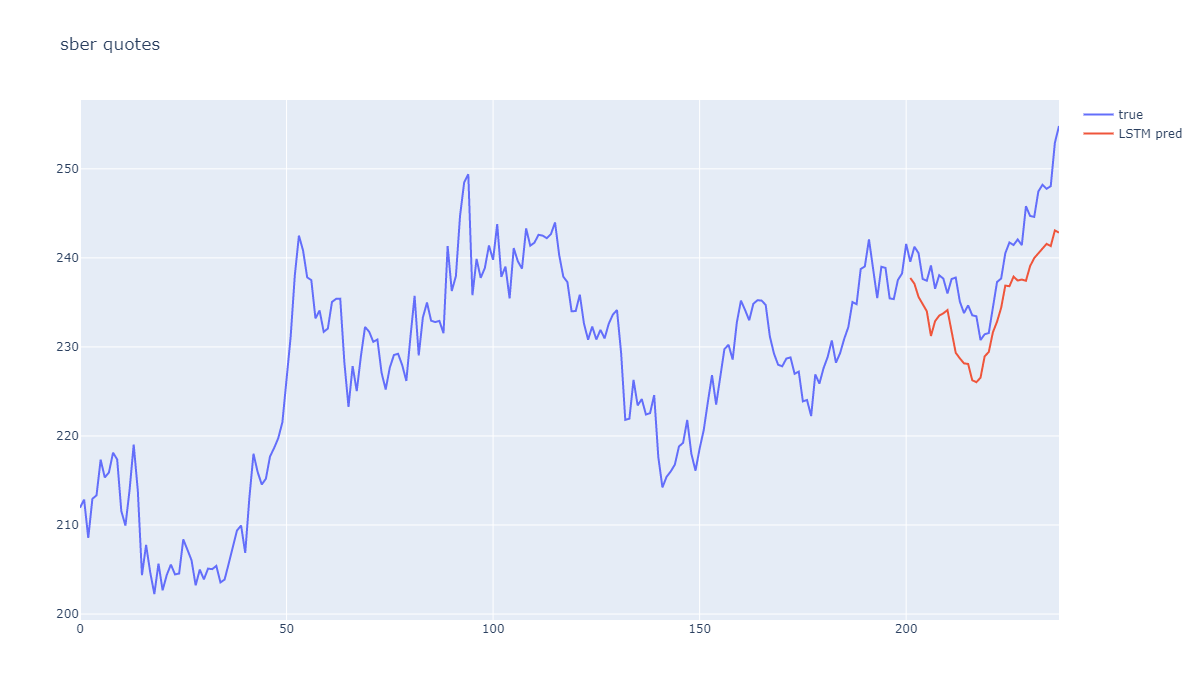

In [59]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=df.y,  mode='lines', name='true'))

fig.add_trace(go.Scatter(x=np.arange(batch_size - test_size + seq_lenght, batch_size), 
                         y=data_predict[:, 0],  mode='lines', name='LSTM pred'))

fig.update_layout(title='sber quotes', autosize=False,
                 width=1000, height=600)

fig.show()

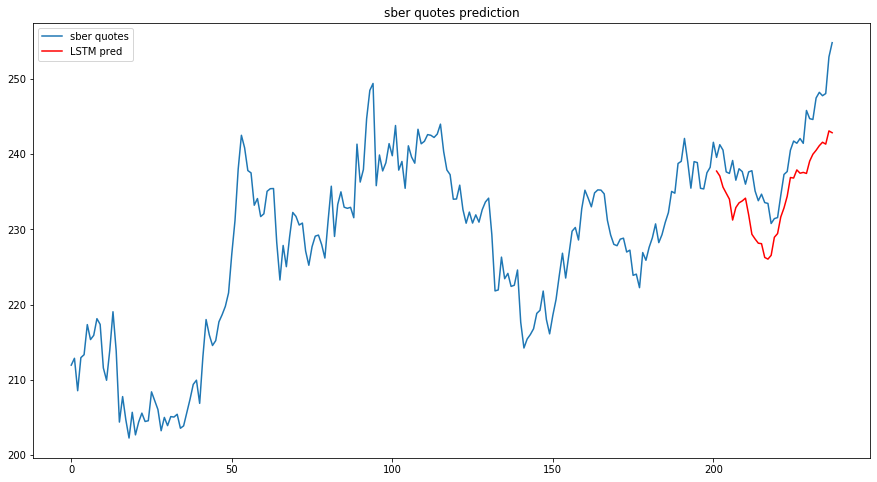

In [60]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))

ax.plot(df.y.reset_index(drop=True), label='sber quotes')

ax.plot(np.arange(batch_size - test_size + seq_lenght, batch_size), 
        data_predict[:, 0], label='LSTM pred', color='r')  #simple prophet model


ax.set_title('sber quotes prediction')

plt.legend()

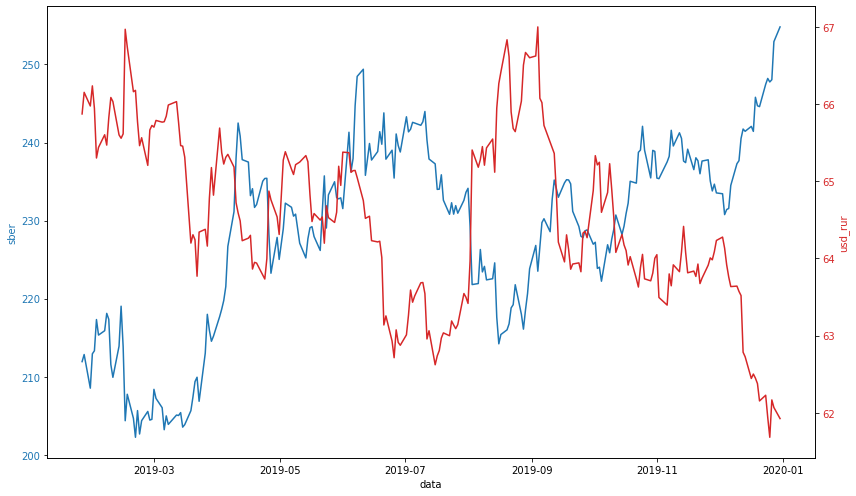

In [61]:
fig, ax1 = plt.subplots(figsize=(12, 7))

color = 'tab:blue'
ax1.set_xlabel('data')
ax1.set_ylabel('sber', color=color)
ax1.plot(df.ds, df.y, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  

color = 'tab:red'
ax2.set_ylabel('usd_rur', color=color) 
ax2.plot(df.ds, df.USDRUB, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.show()


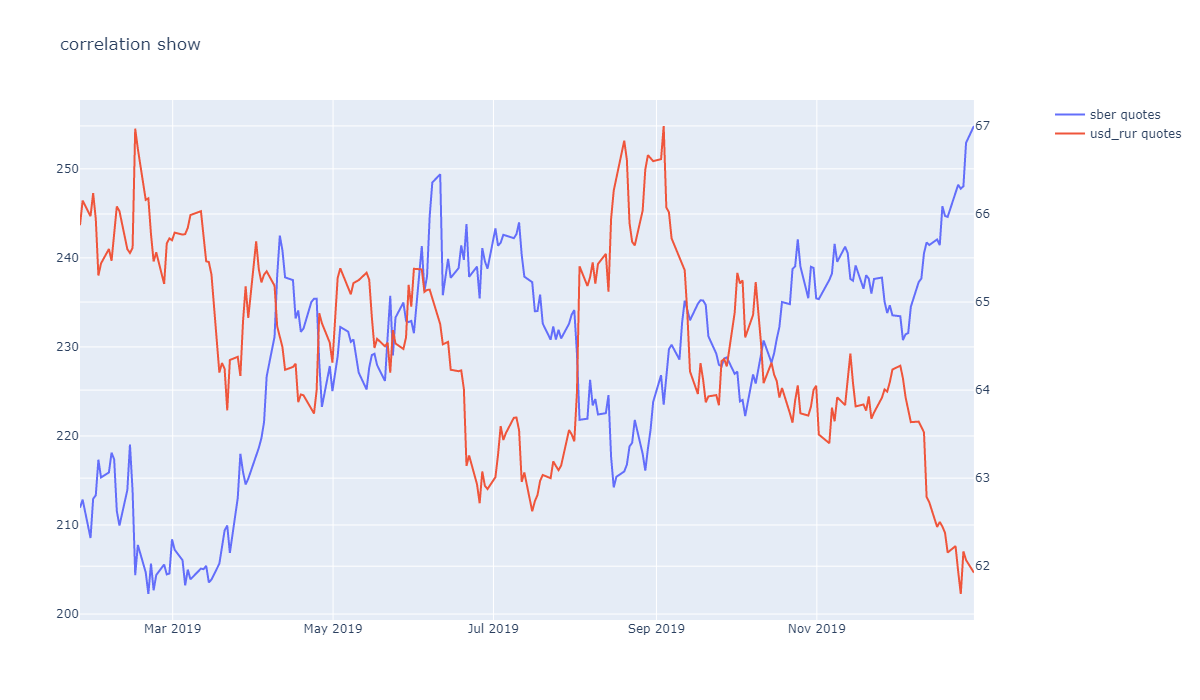

In [62]:
from plotly.subplots import make_subplots
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df.ds, y=df.y, name="sber quotes"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df.ds, y=df.USDRUB, name="usd_rur quotes"),
    secondary_y=True,
)

fig.update_layout(
    title_text="correlation show"
)


fig.show()